## Importing Libraries and Data

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import sys
import scipy.spatial.distance as dist

sys.path.append('./src/modules')

import EDA

In [2]:
df = pd.read_csv('src/data/grailed.csv')

In [3]:
colordf = pd.read_csv('./src/data/colors.csv')

## Data Cleaning

In [4]:
# Drop double index

df.drop(columns = 'Unnamed: 0', inplace = True)

# Drop NaN Values (and rows) from a mostly-complete column

df.dropna(subset = ['Location'], inplace= True)

In [5]:
# Convert and reformat price columns

df.Price = EDA.dollars_to_int(df.Price)
df.NewPrice = EDA.dollars_to_int(df.NewPrice)
df.OldPrice = EDA.dollars_to_int(df.OldPrice)

In [6]:
# Reformat current number of listings column and filling NaN values

df.CurrentListings = EDA.format_listings(df.CurrentListings)
df.CurrentListings.fillna(0, inplace=True)

In [7]:
# Create dummy columns for every size

size_dummies = pd.get_dummies(df.Size)
df.drop(columns= 'Size', inplace = True)
size_dummies.drop(columns = 'XXS', inplace = True)

In [8]:
# Add dummy columns to df

df = pd.concat([df, size_dummies], axis = 1)

In [9]:
# Consolidate price columns

df.Price.fillna(df.NewPrice, inplace = True)

In [10]:
# Create column for amount of price dropped

df['PriceDropped'] = df.OldPrice - df.NewPrice

In [11]:
# Fill rows with no price drops with 0

df['PriceDropped'].fillna(0, inplace = True)

In [12]:
# Drop old columns

df.drop(columns = ['OldPrice', 'NewPrice'], inplace = True)

In [13]:
# Isolate country names in Location column

df.Location = df.Location.str.replace('Shipping: ', '')
df.Location = df.Location.str.replace(' to', '')

In [14]:
# Create location dummy columns and add to df

loc_dummies = pd.get_dummies(df.Location)
loc_dummies.drop(columns = ['- Ask for shipping', 'Add a comment'], inplace = True)
df = pd.concat([df, loc_dummies], axis = 1)

In [15]:
# Reformat Feedback column and fill NA values

df.Feedback = df.Feedback.str.replace(' Feedback', '')
df.Feedback = pd.to_numeric(df.Feedback)
df.Feedback.fillna(0, inplace = True)

In [16]:
# Reformat Number of Items Sold column

df.Sold = df.Sold.str.replace('(', '')
df.Sold = df.Sold.str.replace(')', '')
df.Sold = pd.to_numeric(df.Sold)
df.Sold.fillna(0, inplace = True)

In [17]:
# Fill NaN values in Follower Count with 0

df.FollowerCount.fillna(0, inplace = True)

In [18]:
df.Designer = EDA.bin_designers(df.Designer)

In [19]:
df.Designer.sort_values().unique()

array(['ACNE STUDIOS', 'ADIDAS', 'ANTI SOCIAL SOCIAL CLUB', 'BAND TEES',
       'BAPE', 'CHAMPION', 'CHROME HEARTS', 'COMME DES GARCONS', 'DIOR',
       'DISNEY', 'FEAR OF GOD', 'GIVENCHY', 'GUCCI', 'HAWAIIAN SHIRT',
       'JAPANESE BRAND', 'JAPANESE DESIGNER', 'KAPITAL',
       'MAISON MARGIELA', 'MISC', 'NIKE', 'OFF WHITE', 'PALACE', 'PRADA',
       'RAF SIMMONS', 'RALPH LAUREN', 'RICK OWENS', 'STREETWEAR',
       'STUSSY', 'SUPREME', 'UNIQLO', 'VETEMENTS', 'VINTAGE',
       'YEEZY SEASON'], dtype=object)

In [20]:
# Create dummy columns for binned designers and add to df

designers = pd.get_dummies(df.Designer)
designers.drop(columns= 'DISNEY', inplace = True)
df = pd.concat([df, designers], axis = 1)

In [21]:
df = df.dropna(subset=['Name'])

In [22]:
# Merge color DataFrame with df

colordf.set_index('Unnamed: 0', inplace = True)
maindf = df.merge(colordf, left_index=True, right_index=True)

In [23]:
# Convert color tuples back to int

maindf['0'] = maindf['0'].apply(lambda x: eval(x))
maindf['1'] = maindf['1'].apply(lambda x: eval(x))
maindf['2'] = maindf['2'].apply(lambda x: eval(x))

## EDA

### Visualizing Feature Distributions

In [110]:
df.Price.mean()

140.5216

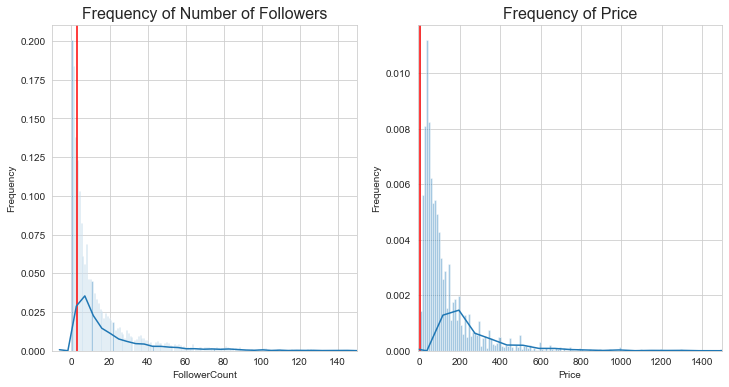

In [124]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(1,2, figsize = (12,6))

ax[0].set_title('Frequency of Number of Followers', size = 16)
ax[0].axvline(2.8, 0, 16.4479, color= 'r', label = 'Mean')
ax[0].set_xlim(-10, 150)
ax[0].set_ylabel('Frequency')
sns.distplot(df.FollowerCount, bins= 1000, ax= ax[0]);

ax[1].set_title('Frequency of Price', size = 16)
ax[1].axvline(2.8,0, 140.5216, color = 'r', label = 'Mean')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(-10, 1500)

sns.distplot(df.Price, bins = 1000, ax = ax[1]);

In [ ]:
# trying to plot color distributions

In [129]:
def hexencode(rgb):
    r=rgb[0]
    g=rgb[1]
    b=rgb[2]
    return '#%02x%02x%02x' % (r,g,b)

for idx, c in enumerate(maindf['0']):
    plt.bar(idx, c[0], color=hexencode(c[1]))

plt.show()

TypeError: 'int' object is not subscriptable

### Using Euclidean distance to calculate color similarity

For EDA, my first step was to develope some functions to test the efficacy of my image processing from the previous notebook. I used SciPy's spatial distance function to calculate the relative distance of the colors throughout my dataset with those of an input item and return the closest matches. 

These functions should provide the foundation for an image search engine of the dataset. 

In [24]:
list_of_tuples = [maindf['0'][0], maindf['1'][0], maindf['2'][0]]
list_of_columns = [maindf['0'], maindf['1'], maindf['2']]

In [25]:
EDA.find_closest_colors(list_of_tuples, list_of_columns, maindf)

Name Designer  Price  \
0      Bape Varsity style Jacket Bathing Ape     BAPE  155.0   
168             Vlone Neighborhood Skull Tee     MISC  135.0   
2228  North Face Never Stop Exploring Hoodie  VINTAGE   22.0   
8533       Vintage Patagonia Big Logo Hoodie    GUCCI   72.0   
5634       Head🔥Guess Spellout Big Logo Tees  VINTAGE  200.0   
8043            Fred Perry tracksuit black L     MISC    3.0   

                    Time    LastBump  \
0     about 14 hours ago         NaN   
168           2 days ago         NaN   
2228      14 minutes ago    (7 days)   
8533        3 months ago  (4 months)   
5634    about 1 hour ago   (23 days)   
8043      23 minutes ago  (3 months)   

                                                   Link            Username  \
0     https://www.grailed.com/listings/18766603-bape...          oghypeshop   
168   https://www.grailed.com/listings/18739497-neig...             nateszn   
2228  https://www.grailed.com/listings/18626417-the-...  dominicschlossberg   
8533  https://www.grailed.com/listings/16345499-pata...   ildargabidull4709   
5634  https://www.grailed.com/listings/18252620-gues...        Vaultwearism   
8043  https://www.grailed.com/listings/17023888-fred...              Migape   

       Sold  Feedback  CurrentListings  ... STREETWEAR STUSSY SUPREME  UNIQLO  \
0     122.0      77.0             59.0  ...          0      0       0       0   
168   172.0      84.0             11.0  ...          0      0       0       0   
2228    8.0       0.0             16.0  ...          0      0       0       0   
8533   69.0      30.0             70.0  ...          0      0       0       0   
5634  161.0      84.0           1015.0  ...          0      0       0       0   
8043  565.0     276.0             54.0  ...          0      0       0       0   

     VETEMENTS VINTAGE YEEZY SEASON                0                1  \
0            0       0            0  (218, 196, 167)  (114, 107, 138)   
168          0       0            0  (181, 141, 139)  (111, 122, 135)   
2228         0       1            0  (188, 186, 183)  (124, 132, 124)   
8533         0       0            0   (34, 137, 204)  (110, 112, 117)   
5634         0       1            0  (197, 171, 153)  (106, 110, 138)   
8043         0       0            0  (217, 219, 176)   (117, 139, 80)   

                    2  
0     (123, 124, 118)  
168     (83, 94, 113)  
2228  (124, 124, 132)  
8533   (98, 109, 114)  
5634  (124, 124, 116)  
8043  (120, 122, 132)  

[6 rows x 67 columns]

Now that I can pull the indices of the closest matches, the next step is to create a function that displays the corresponding image without the background dropped out. Then I can test on a few different images.

I chose to use some of the same images as in the image_process notebook in order to see how successful my removal of backgrounds was as well as the general similarliy of the items.

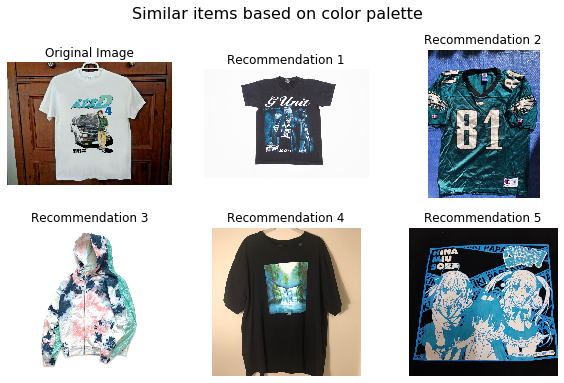

In [26]:
EDA.display_closest_colors(127, list_of_columns, maindf)

These tests seem to indicate that the background removal was a success.

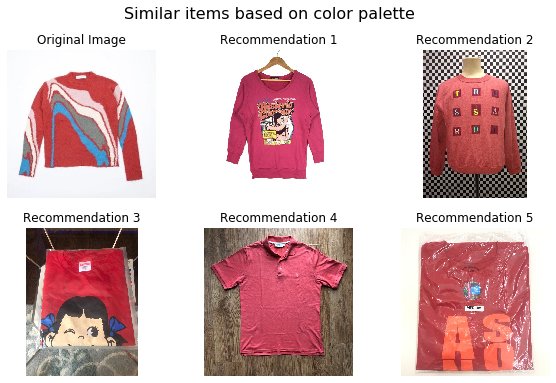

In [27]:
EDA.display_closest_colors(4363, list_of_columns, maindf)

Dense color patterns like this work but with less efficacy- it may be worthwhile later to make a second pass at the data and gather a larger palette.

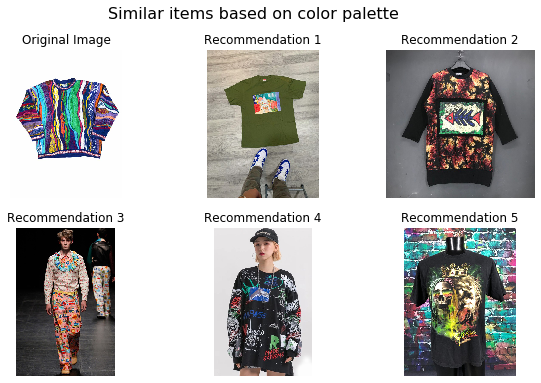

In [28]:
EDA.display_closest_colors(1180, list_of_columns, maindf)

Here's another example of a busy background that the filter has managed to exclude completely.

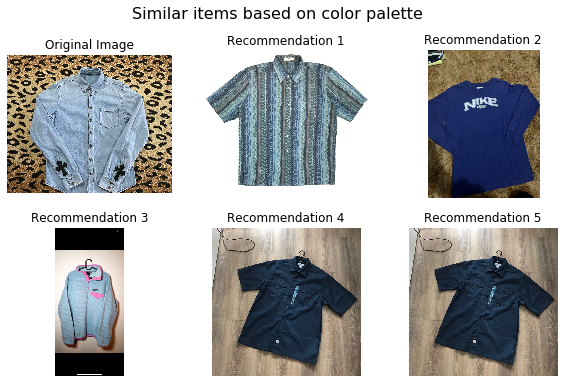

In [29]:
EDA.display_closest_colors(306, list_of_columns, maindf)

Below we can see the filter has found a different listing for the same item, achieving one goal of this project.

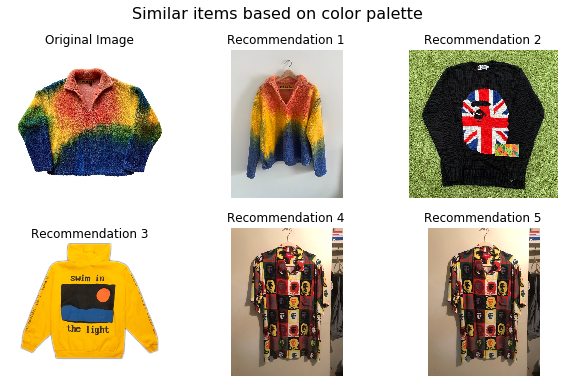

In [30]:
EDA.display_closest_colors(391, list_of_columns, maindf)

Success! There are some cases where the matches aren't perfect, but I think once I factor in the rest of my features I should be able to narrow to the most relevant results.

Now to inspect the rest of my data.

In [31]:
# Create average colors map
def get_average_color(column):
    for i in column:
        one = []
        two = []
        three = []
        one.append(i[0])
        two.append(i[1])
        three.append(i[2])
        return  (np.mean(one), np.mean(two), np.mean(three))


In [32]:
def show_average_colors(list_of_columns):
    average_array = []
    for i in list_of_columns:
        average_array.append(get_average_color(i))
    palette = np.array(average_array)
    plt.imshow(palette)
    plt.axis('off')
    return palette

array([[218., 196., 167.],
       [114., 107., 138.],
       [123., 124., 118.]])

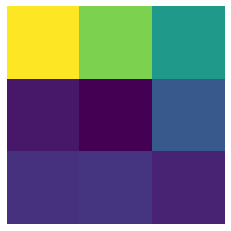

In [33]:
# Fix this to display 3 colors instead of 9

show_average_colors(list_of_columns)

### Checking the data for Multicollinearity

Next I created a correlation heatmap in order to check for collinearity in my data before fitting a couple of simple linear models. While there are some sections of high correlation in the dummy variables and number of sold/number of feedback, overall this data has extremely low correlation across the board. 

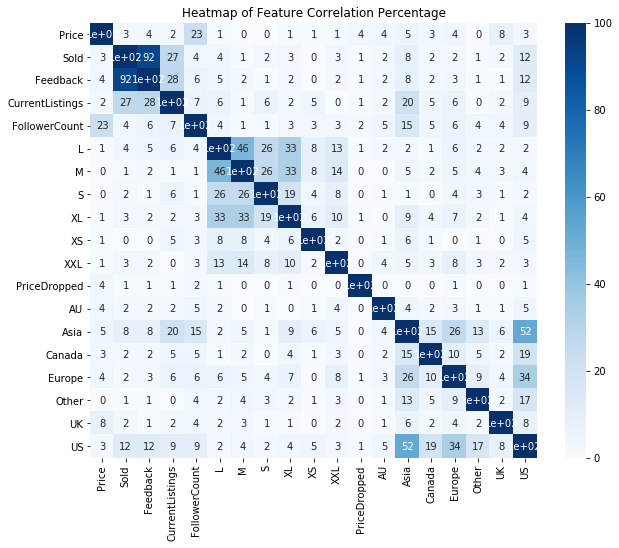

In [34]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap((round(abs(df[['Name', 'Designer', 'Price', 'Time', 'LastBump', 'Link', 'Username',
       'Sold', 'Feedback', 'CurrentListings', 'Description', 'ProfileLink',
       'FeedbackLink', 'FollowerCount', 'FullSize', 'PostedTime', 'BumpedTime',
       'Location', 'L', 'M', 'S', 'XL', 'XS', 'XXL', 'PriceDropped', 'AU',
       'Asia', 'Canada', 'Europe', 'Other', 'UK', 'US']].corr()), 2)*100), annot = True, cmap = 'Blues')
plt.title('Heatmap of Feature Correlation Percentage');

## Feature Engineering

### Creating TF-IDF features

In [35]:
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
maindf.Description

0        Bape Varsity Jacket\nSize M fits true\nRelease...
1        Brand : Vintage Nike sunfaded mini swoosh blac...
2        Comes des garçons black hoodie\nFrom Dover str...
3        90s Faded Uni Blank Tee. Size Medium.\nPit To ...
4        Mens medium\nGood condition other than some we...
                               ...                        
10095    Thanks for favorites our store so that you wil...
10096    Rare!! SUZUKI Sweatshirt Crewneck Small Logo M...
10097             New, never worn. Condition 10/10, size M
10098    90' S Champion Spellout Big Logo Reverse Weave...
10099    Used and signs of wear on buttons as pictured....
Name: Description, Length: 10000, dtype: object

In [37]:
tokenizer = RegexpTokenizer(r'[a-zA-Z][^0-9\/]+')

df['TokenizedDesc'] = df.Description.apply(lambda x: nltk.word_tokenize(x.lower()))

stop_words=set(stopwords.words("english"))

df['TokenizedDesc'] = df['TokenizedDesc'].apply(lambda x: [item for item in x if item not in stop_words])

In [38]:
maindf.Description = maindf.Description.str.replace('\n', ' ')
maindf.Description = maindf.Description.str.replace('[^a-zA-Z ]', '')

In [39]:
tf=TfidfVectorizer(stop_words= {'english'}, analyzer= 'word', max_features=100)
text_tf= tf.fit_transform(maindf['Description'])
text_tf.data.shape

(239571,)

In [40]:
#stem or lemmatize first?

feature_names = tf.get_feature_names()
feature_names

['about',
 'accept',
 'after',
 'all',
 'and',
 'any',
 'are',
 'armpit',
 'as',
 'ask',
 'back',
 'be',
 'before',
 'brand',
 'business',
 'by',
 'check',
 'cm',
 'condition',
 'contact',
 'cotton',
 'day',
 'days',
 'delivery',
 'description',
 'details',
 'dhl',
 'do',
 'dont',
 'express',
 'fits',
 'for',
 'free',
 'from',
 'good',
 'have',
 'if',
 'in',
 'inch',
 'inches',
 'is',
 'it',
 'item',
 'items',
 'length',
 'like',
 'make',
 'may',
 'me',
 'measurement',
 'measurements',
 'more',
 'my',
 'new',
 'no',
 'not',
 'number',
 'of',
 'offers',
 'on',
 'only',
 'or',
 'our',
 'out',
 'payment',
 'paypal',
 'photos',
 'pit',
 'please',
 'price',
 'purchase',
 'questions',
 'read',
 'see',
 'ship',
 'shipped',
 'shipping',
 'shirt',
 'shoulder',
 'size',
 'so',
 'tag',
 'thank',
 'that',
 'the',
 'this',
 'time',
 'to',
 'tracking',
 'us',
 'used',
 'vintage',
 'we',
 'will',
 'with',
 'within',
 'working',
 'worn',
 'you',
 'your']

In [41]:
text_features = pd.DataFrame(text_tf.toarray().transpose(), index = tf.get_feature_names())

In [42]:
text_features = text_features.transpose()

In [43]:
text_features

about    accept     after       all       and       any      are  \
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
1     0.000000  0.083365  0.145884  0.172915  0.000000  0.059571  0.00000   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
3     0.000000  0.000000  0.000000  0.164394  0.000000  0.000000  0.19232   
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
...        ...       ...       ...       ...       ...       ...      ...   
9995  0.094284  0.095265  0.000000  0.000000  0.111437  0.136149  0.00000   
9996  0.094284  0.095265  0.000000  0.000000  0.111437  0.136149  0.00000   
9997  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
9998  0.000000  0.073181  0.000000  0.252985  0.042802  0.052293  0.00000   
9999  0.000000  0.000000  0.000000  0.000000  0.255965  0.000000  0.00000   

      armpit        as       ask  ...      used   vintage        we      will  \
0        0.0  0.000000  0.000000  ...  0.310076  0.000000  0.000000  0.000000   
1        0.0  0.226078  0.000000  ...  0.000000  0.068698  0.000000  0.173661   
2        0.0  0.000000  0.000000  ...  0.448960  0.000000  0.000000  0.000000   
3        0.0  0.000000  0.000000  ...  0.000000  0.391878  0.000000  0.000000   
4        0.0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
...      ...       ...       ...  ...       ...       ...       ...       ...   
9995     0.0  0.000000  0.000000  ...  0.234310  0.078505  0.091306  0.066150   
9996     0.0  0.000000  0.000000  ...  0.234310  0.078505  0.091306  0.066150   
9997     0.0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
9998     0.0  0.066153  0.070937  ...  0.059997  0.060306  0.000000  0.101630   
9999     0.0  0.395612  0.000000  ...  0.358798  0.000000  0.000000  0.000000   

          with    within   working      worn       you      your  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1     0.054873  0.078682  0.166374  0.000000  0.056882  0.061746  
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...        ...       ...       ...       ...       ...       ...  
9995  0.000000  0.000000  0.000000  0.092490  0.130005  0.070560  
9996  0.000000  0.000000  0.000000  0.092490  0.130005  0.070560  
9997  0.000000  0.000000  0.000000  0.687156  0.000000  0.000000  
9998  0.096339  0.000000  0.000000  0.000000  0.299600  0.216810  
9999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[10000 rows x 100 columns]

In [44]:
df_model = maindf[['Price', 
                 'Sold', 
                 'Feedback', 
                 'CurrentListings', 
                 'FollowerCount', 
                 'L', 'M', 'S', 'XL', 'XS', 'XXL',
                 'PriceDropped',
                 'AU', 'Asia', 'Canada', 'Europe', 'UK', 'US',
                 'ACNE STUDIOS',
                 'ADIDAS',
                 'ANTI SOCIAL SOCIAL CLUB',
                 'BAND TEES',
                 'BAPE',
                 'CHAMPION',
                 'CHROME HEARTS', 
                 'COMME DES GARCONS', 
                 'FEAR OF GOD', 
                 'GIVENCHY', 
                 'GUCCI', 
                 'HAWAIIAN SHIRT', 
                 'JAPANESE BRAND', 
                 'JAPANESE DESIGNER', 
                 'KAPITAL', 
                 'MAISON MARGIELA', 
                 'MISC', 
                 'NIKE', 
                 'OFF WHITE', 
                 'PALACE', 
                 'PRADA', 
                 'RAF SIMMONS', 
                 'RALPH LAUREN', 
                 'RICK OWENS', 
                 'STREETWEAR', 
                 'STUSSY', 
                 'SUPREME', 
                 'UNIQLO',
                 'VETEMENTS', 
                 'VINTAGE', 
                 'YEEZY SEASON', 
                 '0', '1', '2']]

In [47]:
df_model = df_model.merge(text_features, left_index=True, right_index=True)

In [48]:
df_model.to_csv('./src/data/model_data.csv')

## Simple Linear Modeling

In [49]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [50]:
df_model.dropna(inplace= True)

In [51]:
X = df_model.drop(columns = ['Feedback', '0', '1', '2'])
y = df_model.Feedback

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
print('Likes Standard Deviation: ', y.std())
print('Mean Likes: ', y.mean())
print('Median Likes: ', y.median())

Likes Standard Deviation:  430.3667848640163
Mean Likes:  180.1014038985961
Median Likes:  37.0


In [53]:
scaler = StandardScaler()
pca = PCA()
# scaled = scaler.fit_transform(X_train)
# test_scaled = scaler.transform(X_test)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [54]:
np.cumsum(pca.explained_variance_ratio_)

array([0.83009158, 0.94681059, 0.9896569 , 0.99984982, 0.99999951,
       0.99999956, 0.99999961, 0.99999966, 0.9999997 , 0.99999972,
       0.99999975, 0.99999977, 0.99999978, 0.99999979, 0.9999998 ,
       0.99999981, 0.99999982, 0.99999983, 0.99999983, 0.99999984,
       0.99999985, 0.99999985, 0.99999986, 0.99999986, 0.99999987,
       0.99999987, 0.99999987, 0.99999988, 0.99999988, 0.99999988,
       0.99999989, 0.99999989, 0.99999989, 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.99999991, 0.99999991, 0.99999991,
       0.99999991, 0.99999991, 0.99999992, 0.99999992, 0.99999992,
       0.99999992, 0.99999992, 0.99999993, 0.99999993, 0.99999993,
       0.99999993, 0.99999993, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999995,
       0.99999995, 0.99999995, 0.99999995, 0.99999995, 0.99999995,
       0.99999995, 0.99999995, 0.99999996, 0.99999996, 0.99999996,
       0.99999996, 0.99999996, 0.99999996, 0.99999996, 0.99999

In [55]:
lr = LinearRegression()

lr.fit(X_train_pca, y_train)

y_pred = lr.predict(X_train_pca)
y_test_pred = lr.predict(pca.transform(X_test_pca))

In [56]:
print('Train RMSE: ', mean_squared_error(y_train, y_pred)**.5)
# print('Test RMSE: ', mean_squared_error(y_test, y_test_pred**.5))

Train RMSE:  170.00837393702957


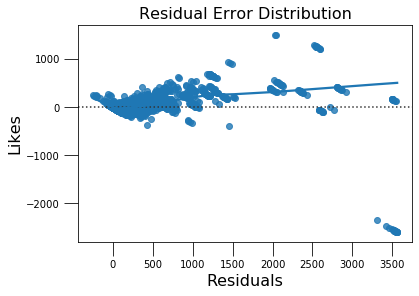

In [57]:
sns.residplot(y_pred, y_train, lowess=True)
plt.xlabel('Residuals', fontsize = 16)
plt.ylabel('Likes', fontsize = 16)
plt.title('Residual Error Distribution', fontsize = 16)
plt.tick_params(size = 14)

In [58]:
X2 = df_model.drop(columns = ['Price', '0', '1', '2'])
y2 = df_model.Price

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)

In [59]:
print('Price Standard Deviation: ', y2.std())
print('Mean Price: ', y2.mean())
print('Median Price: ', y2.median())

Price Standard Deviation:  239.2590224943884
Mean Price:  141.13725886274113
Median Price:  79.0


In [60]:
scaler1 = StandardScaler()
pca1 = PCA()
# scaled1 = scaler1.fit_transform(X_train2)
# test_scaled1 = scaler1.transform(X_test2)
X_train_pca1 = pca1.fit_transform(X_train2)
X_test_pca1 = pca1.transform(X_test2)

In [61]:
lr2 = LinearRegression()

lr2.fit(X_train_pca1, y_train2)

y_pred2 = lr2.predict(X_train_pca1)
y_test_pred2 = lr2.predict(X_test_pca1)

In [62]:
print('Train RMSE: ', mean_squared_error(y_train2, y_pred2)**.5)
print('Test RMSE: ', mean_squared_error(y_test2, y_test_pred2**.5))

Train RMSE:  202.70798739054888
Test RMSE:  109973.89731545316


Pretty extreme heteroscedasticity below. My vanilla model is going to need some serious work- as shown by the RMSE on the test set above.

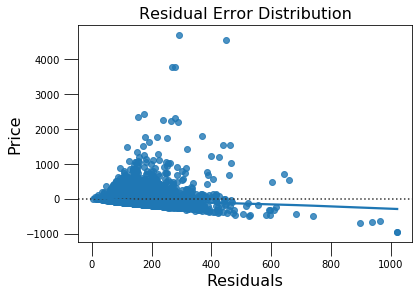

In [63]:
sns.residplot(y_pred2, y_train2, lowess=True)
plt.xlabel('Residuals', fontsize = 16)
plt.ylabel('Price', fontsize = 16)
plt.title('Residual Error Distribution', fontsize = 16)
plt.tick_params(size = 14)

In [ ]:
# PCA
# K-Means/support vector Clustering?
# VIF analysis?
# Recursive Feature Elimination?
# SVM?